<img width="10%" alt="Naas" src="https://landen.imgix.net/jtci2pxwjczr/assets/5ice39g4.png?w=160"/>


# LinkedIn - Follow content views weekly
<a href="https://app.naas.ai/user-redirect/naas/downloader?url=https://raw.githubusercontent.com/jupyter-naas/awesome-notebooks/master/LinkedIn/Linkedin_Follow_content_views_from_profile.ipynb" target="_parent"><img src="https://naasai-public.s3.eu-west-3.amazonaws.com/open_in_naas.svg"/></a>

**Tags:** #linkedin #html #plotly #csv #image #content #analytics #dependency

**Author:** [Florent Ravenel](https://www.linkedin.com/in/florent-ravenel/)

This notebook follows the evolution of content views on LinkedIn.

<div class="alert alert-info" role="info" style="margin: 10px">
<b>Requirements:</b><br>
To run this notebook, you must have already run <b>LinkedIn_Get_profile_posts_stats.ipynb</b> or <b>LinkedIn_Get_company_posts_stats.ipynb</b> to get your post stats in CSV.<br>
</div>

## Input

### Import libraries

In [1]:
import naas
import pandas as pd
from datetime import datetime
import plotly.graph_objects as go

### Setup Variables

In [2]:
# Input
csv_input = f"LINKEDIN_PROFILE_POSTS.csv" # CSV path with your posts stats generated with 'LinkedIn_Get_profile_posts_stats.ipynb' or 'LinkedIn_Get_company_posts_stats.ipynb'
TITLE = "Views" # Chart title
COL_VALUE = "VIEWS" # Column to sum

# Outputs
name_output = "LINKEDIN_FOLLOW_CONTENT_VIEWS_WEEKLY"
csv_output = f"{name_output}.csv"
html_output = f"{name_output}.html"
image_output = f"{name_output}.png"

### Setup Naas dependency

In [ ]:
naas.dependency.add()

#-> Uncomment the line below to remove your dependency
# naas.dependency.delete()

## Model

### Get your posts
Get posts feed from CSV stored in your local (Returns empty if CSV does not exist)

In [4]:
def read_csv(file_path):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError as e:
        # Empty dataframe returned
        return pd.DataFrame()
    return df

df_posts = read_csv(csv_input)
print("✅ Posts fetched:", len(df_posts))
df_posts.head(1)

✅ Posts fetched: 22


,ACTIVITY_ID,PAGINATION_TOKEN,PUBLISHED_DATE,AUTHOR_NAME,AUTHOR_URL,SUBDESCRIPTION,TITLE,TEXT,CHARACTER_COUNT,TAGS,...,POLL_ID,POLL_QUESTION,POLL_RESULTS,POST_URL,VIEWS,COMMENTS,LIKES,SHARES,ENGAGEMENT_SCORE,DATE_EXTRACT
0,6947591561702473728,dXJuOmxpOmFjdGl2aXR5OjY5NDc1OTE1NjE3MDI0NzM3Mj...,2022-06-28 16:48:28+02:00,Florent Ravenel,https://www.linkedin.com/in/ACoAABCNSioBW3YZHc...,1 day ago,✏️ Are you creating content on your LinkedIn p...,✏️ Are you creating content on your LinkedIn p...,1351,#data #socialmedia #linkedin #project #buildin...,...,NaN,NaN,NaN,https://www.linkedin.com/feed/update/urn:li:ac...,2310,19,31,0,0.0216,2022-06-30 16:46:26


### Create trend dataframe

In [8]:
DATE_FORMAT = "%Y-%m-%d"
PERIOD = "%Y%U"
PERIOD_D = "%Y-W%U"
PERIOD_TEXT = "This week"

def get_trend(df_init,
              col_date,
              col_value,
              agg_value,
              period_rolling=12):
    # Init variable
    df = df_init.copy()
    
    # Groupby period
    if isinstance(col_value, list):
        df["VALUE"] = 0
        for c in col_value:
            df[c] = df[c].astype(float)
            df["VALUE"] = df["VALUE"] + df[c]    
        col_value = "VALUE"
    elif agg_value == "sum":
        df[col_value] = df[col_value].astype(float)
    df[col_date] = pd.to_datetime(df[col_date].str[:-6]).dt.strftime(DATE_FORMAT)
    df = df.groupby(col_date, as_index=False).agg({col_value: agg_value})
    
    # Rename column
    to_rename = {
        col_date: "DATE_ISO",
        col_value: "VALUE"
    }
    df = df.rename(columns=to_rename)
    
    # Reindex value
    d = datetime.now().date()
    d2 = df.loc[df.index[0], "DATE_ISO"]
    idx = pd.date_range(d2, d, freq = "D")    
    df.set_index("DATE_ISO", drop=True, inplace=True)
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=0)
    df["DATE_ISO"] = pd.DatetimeIndex(df.index)
    
    # Groupby month
    df["DATE"] = pd.to_datetime(df["DATE_ISO"], format=DATE_FORMAT).dt.strftime(PERIOD)
    # Plotly: Date display
    df["DATE_D"] = pd.to_datetime(df["DATE_ISO"], format=DATE_FORMAT).dt.strftime(PERIOD_D)
    df = df.groupby(["DATE", "DATE_D"], as_index=False).agg({"VALUE": agg_value})

    # Calc variation
    for index, row in df.iterrows():
        if index > 0:
            n = df.loc[df.index[index], "VALUE"]
            n_1 = df.loc[df.index[index-1], "VALUE"]
            df.loc[df.index[index], "VALUE_COMP"] = n_1
            df.loc[df.index[index], "VARV"] = n - n_1
            if n_1 > 0:
                df.loc[df.index[index], "VARP"] = (n - n_1) / abs(n_1)
    df = df.fillna(0)
    
    # Plotly: Value display
    df["VALUE_D"] = "<b><span style='font-family: Arial;'>" + df["VALUE"].map("{:,.0f}".format).str.replace(",", " ") + "</span></b>"
    
    # Plotly: Variation display
    df["VARV_D"] = df["VARV"].map("{:,.0f}".format).str.replace(",", " ")
    df.loc[df["VARV"] >= 0, "VARV_D"] = "+" + df["VARV_D"]
    df["VARP_D"] = df["VARP"].map("{:,.0%}".format).str.replace(",", " ")
    df.loc[df["VARP"] >= 0, "VARP_D"] = "+" + df["VARP_D"]
    
    # Plotly: hovertext
    df["TEXT"] = ("<b><span style='font-size: 14px;'>" + df["DATE_D"].astype(str) + ": " + df["VALUE_D"] + "</span></b><br>"
                  "<span style='font-size: 12px;'>" + f"{PERIOD_TEXT}: " + df["VARV_D"] + " (" + df["VARP_D"] + ")</span>")
    
    # Return month rolling
    return df[-period_rolling:].reset_index(drop=True)

df_trend = get_trend(df_posts,
                     col_date="PUBLISHED_DATE",
                     col_value=COL_VALUE,
                     agg_value="sum")
df_trend

,DATE,DATE_D,VALUE,VALUE_COMP,VARV,VARP,VALUE_D,VARV_D,VARP_D,TEXT
0,202215,2022-W15,324.0,0.0,324.0,0.000000,<b><span style='font-family: Arial;'>324</span...,+324,+0%,<b><span style='font-size: 14px;'>2022-W15: <b...
1,202216,2022-W16,2687.0,324.0,2363.0,7.293210,<b><span style='font-family: Arial;'>2 687</sp...,+2 363,+729%,<b><span style='font-size: 14px;'>2022-W16: <b...
2,202217,2022-W17,0.0,2687.0,-2687.0,-1.000000,<b><span style='font-family: Arial;'>0</span></b>,-2 687,-100%,<b><span style='font-size: 14px;'>2022-W17: <b...
3,202218,2022-W18,0.0,0.0,0.0,0.000000,<b><span style='font-family: Arial;'>0</span></b>,+0,+0%,<b><span style='font-size: 14px;'>2022-W18: <b...
4,202219,2022-W19,5518.0,0.0,5518.0,0.000000,<b><span style='font-family: Arial;'>5 518</sp...,+5 518,+0%,<b><span style='font-size: 14px;'>2022-W19: <b...
5,202220,2022-W20,3313.0,5518.0,-2205.0,-0.399601,<b><span style='font-family: Arial;'>3 313</sp...,-2 205,-40%,<b><span style='font-size: 14px;'>2022-W20: <b...
6,202221,2022-W21,7192.0,3313.0,3879.0,1.170842,<b><span style='font-family: Arial;'>7 192</sp...,+3 879,+117%,<b><span style='font-size: 14px;'>2022-W21: <b...
7,202222,2022-W22,4413.0,7192.0,-2779.0,-0.386402,<b><span style='font-family: Arial;'>4 413</sp...,-2 779,-39%,<b><span style='font-size: 14px;'>2022-W22: <b...
8,202223,2022-W23,4064.0,4413.0,-349.0,-0.079085,<b><span style='font-family: Arial;'>4 064</sp...,-349,-8%,<b><span style='font-size: 14px;'>2022-W23: <b...
9,202224,2022-W24,675.0,4064.0,-3389.0,-0.833907,<b><span style='font-family: Arial;'>675</span...,-3 389,-83%,<b><span style='font-size: 14px;'>2022-W24: <b...


## Output

### Display linechart

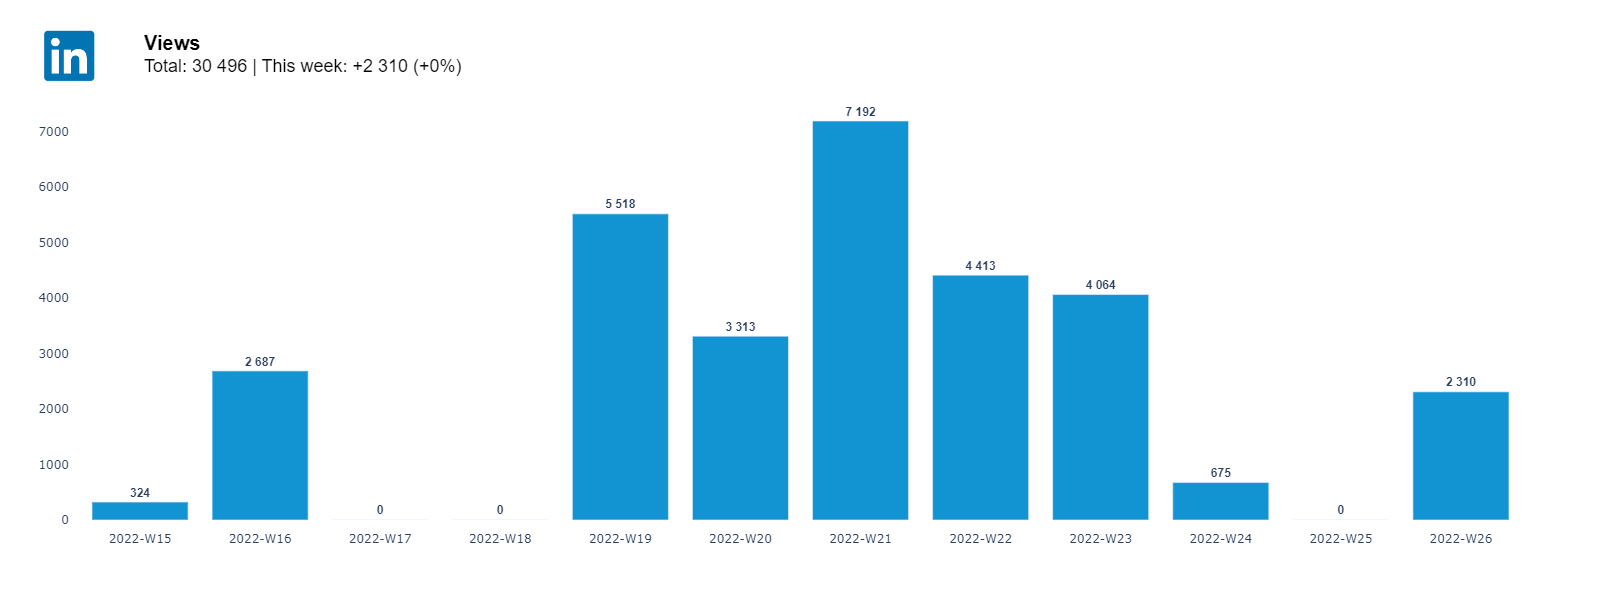

In [9]:
LOGO = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/LinkedIn_logo_initials.png/800px-LinkedIn_logo_initials.png" # Chart logo
COLOR = "#1293d2" # Chart primary color

def create_barchart(df,
                    label="DATE_D",
                    value="VALUE",
                    value_d="VALUE_D",
                    text="TEXT"):
    # Init
    fig = go.Figure()
    
    # Create fig
    fig.add_trace(
        go.Bar(
            x=df[label],
            y=df[value],
            text=df[value_d],
            textposition="outside",
            hoverinfo="text",
            hovertext=df[text],
            marker=dict(color=COLOR)
        )
    )
    # Add logo
    fig.add_layout_image(
        dict(
            source=LOGO,
            xref="paper",
            yref="paper",
            x=0.01,
            y=1.045,
            sizex=0.12,
            sizey=0.12,
            xanchor="right",
            yanchor="bottom"
        )
    )
    fig.update_traces(showlegend=False)
    # Plotly: Create title
    total_value = "{:,.0f}".format(df[value].sum()).replace(",", " ")
    varv = df.loc[df.index[-1], "VARV"]
    varp = df.loc[df.index[-1], "VARP"]
    varv_d = "{:,.0f}".format(varv).replace(",", " ")
    varp_d = "{:,.0%}".format(varp).replace(",", " ")
    if varv >= 0:
        varv_d = f"+{varv_d}"
        varp_d = f"+{varp_d}"
    title = f"<b><span style='font-size: 20px;'>{TITLE}</span></b><br><span style='font-size: 18px;'>Total: {total_value} | {PERIOD_TEXT}: {varv_d} ({varp_d})</span>"
    fig.update_layout(
        title=title,
        title_x=0.09,
        title_font=dict(family="Arial", color="black"),
        paper_bgcolor="#ffffff",
        plot_bgcolor="#ffffff",
        width=1200,
        height=600,
        margin_pad=10,
    )
    fig.show()
    return fig

fig = create_barchart(df_trend)

### Save and share your csv file

In [ ]:
# Save your dataframe in CSV
df_trend.to_csv(csv_output, index=False)

# Share output with naas
naas.asset.add(csv_output)

#-> Uncomment the line below to remove your asset
# naas.asset.delete(csv_output)

### Save and share your graph in HTML


In [ ]:
# Save your graph in HTML
fig.write_html(html_output)

# Share output with naas
naas.asset.add(html_output, params={"inline": True})

#-> Uncomment the line below to remove your asset
# naas.asset.delete(html_output)

### Save and share your graph in image


In [ ]:
# Save your graph in PNG
fig.write_image(image_output)

# Share output with naas
naas.asset.add(image_output)

#-> Uncomment the line below to remove your asset
# naas.asset.delete(image_output)